In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from warnings import filterwarnings

In [4]:
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

In [5]:
filterwarnings('ignore', message='findfont')

In [6]:
SEED = 3264602 # from random.org

np.random.seed(SEED)

In [54]:
N = 100

μ_actual = np.array([1, -2])
Σ_actual = np.array([[0.5, -0.3],
                     [-0.3, 2.]])

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)

In [55]:
var, U = np.linalg.eig(Σ_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

In [56]:
print(var)
print(angle)

[ 0.44222528  2.05777472]
10.9007047432


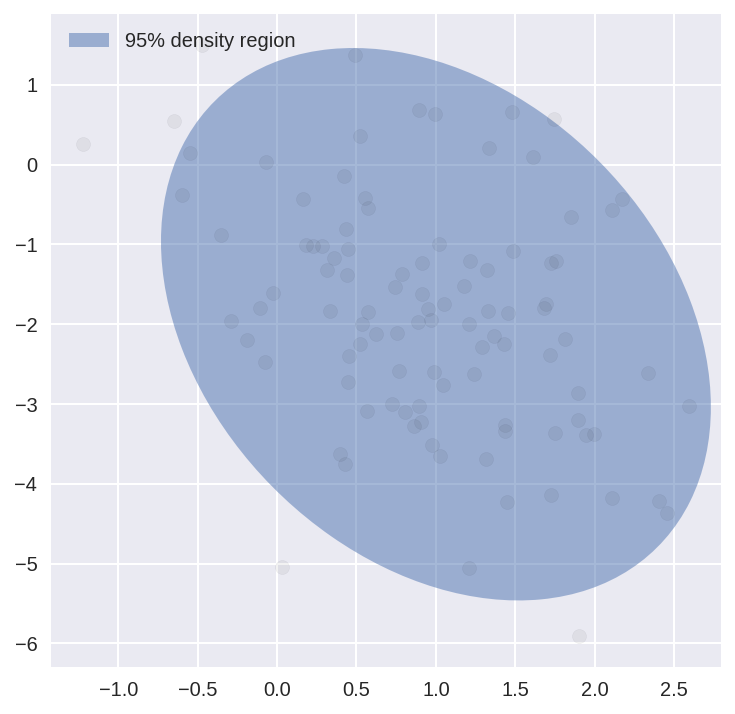

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ['95% density region'], loc=2);

In [58]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.HalfCauchy.dist(2.5))

In [59]:
packed_L.tag.test_value.shape

(3,)

In [60]:
with model:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))

In [61]:
L.tag.test_value.shape

(2, 2)

In [62]:
with model:
    μ = pm.Normal('μ', 0., 10., shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal('obs', μ, chol=L, observed=x)

In [63]:
with model:
    trace = pm.sample(random_seed=SEED, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:03<00:00, 256.36it/s]


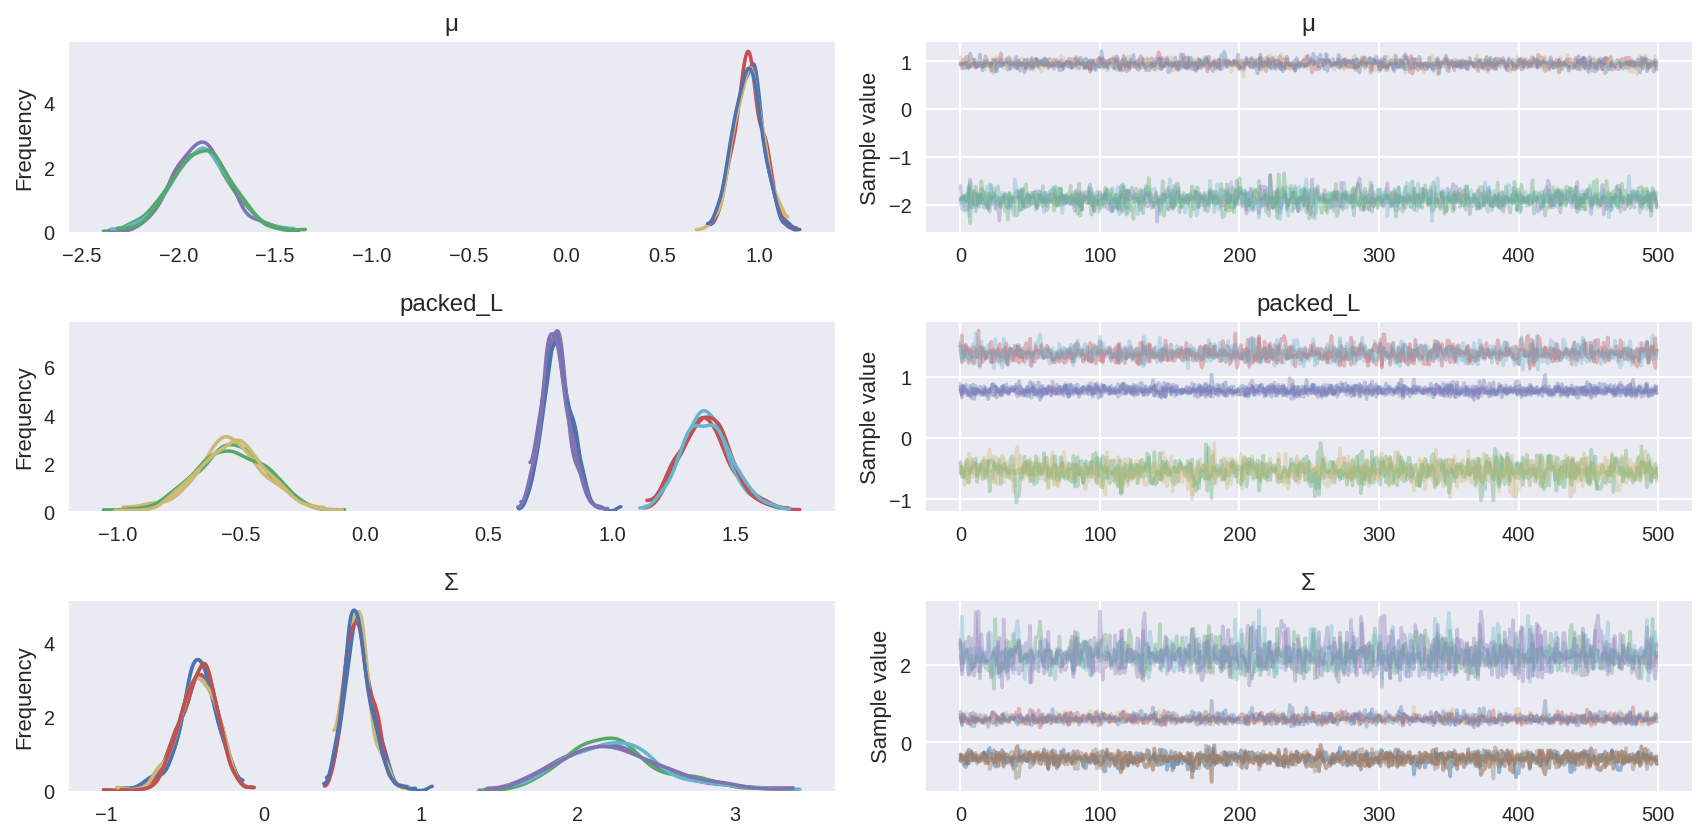

In [64]:
pm.traceplot(trace);

In [65]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

1.001786193295684

In [66]:
μ_post = trace['μ'].mean(axis=0)
1 - μ_post / μ_actual

array([ 0.05668687,  0.06001947])

In [67]:
Σ_post = trace['Σ'].mean(axis=0)
1 - Σ_post / Σ_actual

array([[-0.21108918, -0.40689738],
       [-0.40689738, -0.11762826]])

In [68]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180. / np.pi * np.arccos(np.abs(U_post[0, 0]))

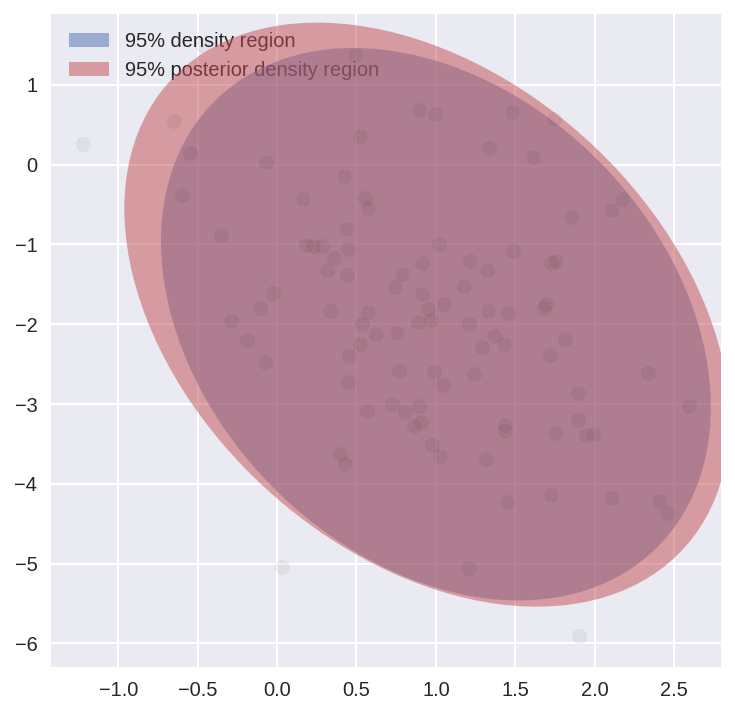

In [70]:
fig, ax = plt.subplots(figsize=(6, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

e_post = Ellipse(μ_post, 2 * np.sqrt(5.991 * var_post[0]),
                 2 * np.sqrt(5.991 * var_post[1]),
                 angle=angle_post)
e_post.set_alpha(0.5)
e_post.set_facecolor(red)
e_post.set_zorder(10);
ax.add_artist(e_post);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
rect_post = plt.Rectangle((0, 0), 1, 1, fc=red, alpha=0.5)
ax.legend([rect, rect_post],
          ['95% density region',
           '95% posterior density region'],
          loc=2);

In [21]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  ========  ==========================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\mu`
 |  Variance  :math:`\dfrac{1}{\tau}` or :math:`\sigma^2`
 |  ========  ==========================================
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      x = np.linspace(-5.0, 5.0, 1000)
 |      fig, ax = plt.subplots()
 |      f = lambda mu, sd : st.